In [127]:
import os
import numpy as np
import networkx as nx
import pandas as pd
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_dir = "../data"
os.listdir(data_dir)

['bus_stops_wszone.dbf',
 'bus_stops_wszone.shp',
 'net_202001_15.net',
 'OD_bus',
 'net_202001_05.net',
 'net_202001_06.net',
 'origin_destination_train_201912.csv.xz',
 'train_station_wszone.prj',
 'origin_destination_train_202001.csv.xz',
 'train_station_wszone.dbf',
 'OD_202001_weekend.csv.xz',
 'net_202001_22.net',
 'subzone_centroid.csv',
 'OD_201912_weekday.csv.xz',
 'origin_destination_bus_201911.csv.xz',
 'net_202001_19.net',
 'net_202001_18.net',
 'train_station_wszone.cpg',
 'OD_PT',
 'train_station_wszone.shx',
 'net_202001_10.net',
 'OD_201911_weekend.csv.xz',
 'origin_destination_train_201911.csv.xz',
 'net_202001_weekend.net',
 'subzone_centroid_pos.json',
 'net_202001_21.net',
 'origin_destination_bus_202001.csv.xz',
 'OD_201912_weekend.csv.xz',
 'net_202001_07.net',
 'origin_destination_bus_201912.csv.xz',
 'net_202001_23.net',
 'region-2014',
 'train_station_wszone.shp',
 'net_202001_weekday.net',
 'net_202001_16.net',
 'OD_train',
 'bus_stops_wszone.shx',
 'OD_202001

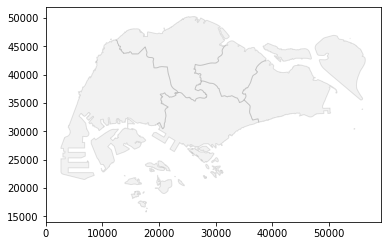

In [4]:
os.listdir("../data")
region = gpd.read_file("../data/region-2014/MP14_REGION_WEB_PL.shp")
region.plot(color="grey", edgecolor="k", alpha=0.1)

In [5]:
with open(os.path.join("../data", 'subzone_centroid_pos.json'), 'r') as fread:
    pos = json.load(fread)
pos["MARINA SOUTH"]

[31595.83574613999, 29220.18737674884]

In [6]:
day = "weekday" # "weekend"
fp = os.path.join(data_dir, "net_202001_{}.net".format(day))
dg1 = nx.read_pajek(fp)
dg1.number_of_nodes(), dg1.number_of_edges()

(303, 30043)

In [62]:
all_weights = []
for u,v,d in dg1.edges(data=True):
    all_weights.append(d["weight"])
median_weight = np.median(all_weights)
#mean_weight = np.mean(all_weights)
#std_weight = np.std(all_weights)
min_weight = min([ w/median_weight for w in all_weights ])
mean_weight, median_weight, min([ w/mean_weight for w in all_weights ]), min([ w/median_weight for w in all_weights ])

(49615.888692873545, 4669.0, 2.0154833992596256e-05, 0.00021417862497322766)

In [109]:
dg1b = nx.DiGraph()
for u,v,d in dg1.edges(data=True):
    w = (d["weight"]/median_weight)/min_weight
    dg1b.add_edge(u, v, weight=w)
dg1b.number_of_nodes(), dg1b.number_of_edges()

(303, 30043)

In [95]:
i = 0
for u,v,d in dg1b.edges(data=True):
    """
    print(d["weight"])
    if i>10: 
        break
    i+=1
    """
    if d["weight"]<=1:
        print(u,v, d["weight"])
        break

CHANGI AIRPORT BANGKIT 1.0


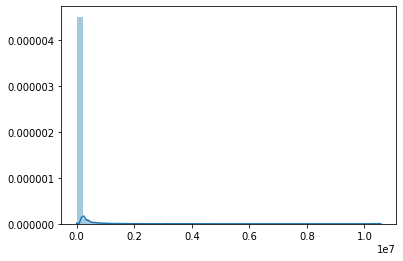

In [96]:
temp = []
for u,v,d in dg1b.edges(data=True):
    temp.append(d["weight"])
sns.distplot(temp)

In [97]:
widegs = dict(dg1b.in_degree(weight="weight"))
nidegs = dict(dg1b.in_degree(weight=None))
wodegs = dict(dg1b.out_degree(weight="weight"))
nodegs = dict(dg1b.out_degree(weight=None))
"""
mean_widegs = np.mean(list(widegs.values()))
widegs = { k:v/mean_widegs for k,v in widegs.items() }
min_wid = min(list(widegs.values()))
widegs = { k:round(v/min_wid, 0) for k,v in widegs.items() }

mean_wodegs = np.mean(list(wodegs.values()))
wodegs = { k:v/mean_wodegs for k,v in wodegs.items() }
min_wod = min(list(wodegs.values()))
wodegs = { k:round(v/min_wod, 0) for k,v in wodegs.items() }
"""

'\nmean_widegs = np.mean(list(widegs.values()))\nwidegs = { k:v/mean_widegs for k,v in widegs.items() }\nmin_wid = min(list(widegs.values()))\nwidegs = { k:round(v/min_wid, 0) for k,v in widegs.items() }\n\nmean_wodegs = np.mean(list(wodegs.values()))\nwodegs = { k:v/mean_wodegs for k,v in wodegs.items() }\nmin_wod = min(list(wodegs.values()))\nwodegs = { k:round(v/min_wod, 0) for k,v in wodegs.items() }\n'

In [99]:
alpha = 1.
beta = 1.

com_idegs = {}
com_odegs = {}
for n in dg1b.nodes():
    cdi = (nidegs[n]**alpha * widegs[n]**beta)**(1./(alpha+beta))
    cdi = int(round(cdi, 0))
    cdo = (nodegs[n]**alpha * wodegs[n]**beta)**(1./(alpha+beta))
    cdo = int(round(cdo, 0))
    #print(cdi, cdo, nidegs[n], widegs[n])
    com_idegs[n] = cdi
    com_odegs[n] = cdo
    #break

In [210]:
import networkx as nx
from tqdm import tqdm

def calculate_ki_prime(dg_temp, weight="weight", direction="in", alpha=1., beta=1.):
    if direction=="in":
        wdegs = dict(dg_temp.in_degree(weight=weight))
        ndegs = dict(dg_temp.in_degree(weight=None))
    else:
        wdegs = dict(dg_temp.out_degree(weight=weight))
        ndegs = dict(dg_temp.out_degree(weight=None))
    com_degs = {}
    for n in dg_temp.nodes():
        cd = (ndegs[n]**alpha * wdegs[n]**beta)**(1./(alpha+beta))
        cd = int(round(cd, 0))
        com_degs[n] = cd
    return com_degs


def prune_graph(dg_temp, weight="weight", direction="in", alpha=1., beta=1.):
    ki_prime = calculate_ki_prime(dg_temp, weight=weight, direction=direction, alpha=alpha, beta=beta)
    min_ki = min(list(ki_prime.values()))
    prune_nodes = [ n for n,v in ki_prime.items() if v<=min_ki ]
    dg_temp.remove_nodes_from(prune_nodes)
    done = False
    while not(done):
        ki_prime = calculate_ki_prime(dg_temp, weight=weight, direction=direction, alpha=alpha, beta=beta)
        cur_min_ki = min(list(ki_prime.values()))
        if cur_min_ki<=min_ki:
            cur_prune_nodes = [ n for n,v in ki_prime.items() if v<=min_ki ]
            dg_temp.remove_nodes_from(cur_prune_nodes)
            prune_nodes.extend(cur_prune_nodes)
            if dg_temp.number_of_nodes()<=0:
                done = True
        else:
            done = True
    return dg_temp, min_ki, prune_nodes


def filtering_edge_weight(dg_temp, weight="weight", filter_edge_weight=0):
    edges = defaultdict(int)
    for u,v,d in dg_temp.edges(data=True):
        w = d[weight]
        if w>filter_edge_weight:
            edges[(u, v)]+=w
    dg_temp2 = nx.DiGraph()
    dg_temp2.add_nodes_from(dg_temp.nodes())
    dg_temp2.add_edges_from([ (k[0], k[1], {weight: v} ) for k,v in edges.items() ])
    return dg_temp2


def decomposition(dg_temp, weight="weight", direction="in", alpha=1., beta=1., filter_edge_weight=None, group_k_by=1):
    if not(filter_edge_weight is None):
        dg_temp = filtering_edge_weight(dg_temp, weight=weight, filter_edge_weight=filter_edge_weight)
    kshell = {}
    kshell_val = {}
    ks = 1
    pbar = tqdm(total=dg_temp.number_of_nodes())
    while dg_temp.number_of_nodes()>0:
        dg_temp, min_ki, prune_nodes = prune_graph(dg_temp, weight=weight, direction=direction, alpha=alpha, beta=beta)
        kshell[ks] = prune_nodes
        kshell_val[ks] = min_ki
        #print("done for ks={}, value={}".format(ks, min_ki))
        pbar.update(len(prune_nodes))
        ks+=1
    pbar.close()
    node_ks = {}
    for k,vs in kshell.items():
        for n in vs:
            node_ks[n] = int(kshell_val[k]/group_k_by)
    return node_ks

In [211]:
node_ks = decomposition(dg1b.copy(), direction="in", alpha=1., beta=1., filter_edge_weight=1000, group_k_by=1)


100%|██████████| 303/303 [00:03<00:00, 98.48it/s] 


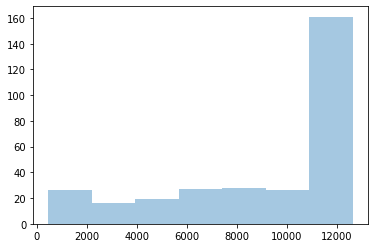

In [212]:
sns.distplot(list(node_ks.values()),kde=False)#, bins=[i*1 for i in range(9)])

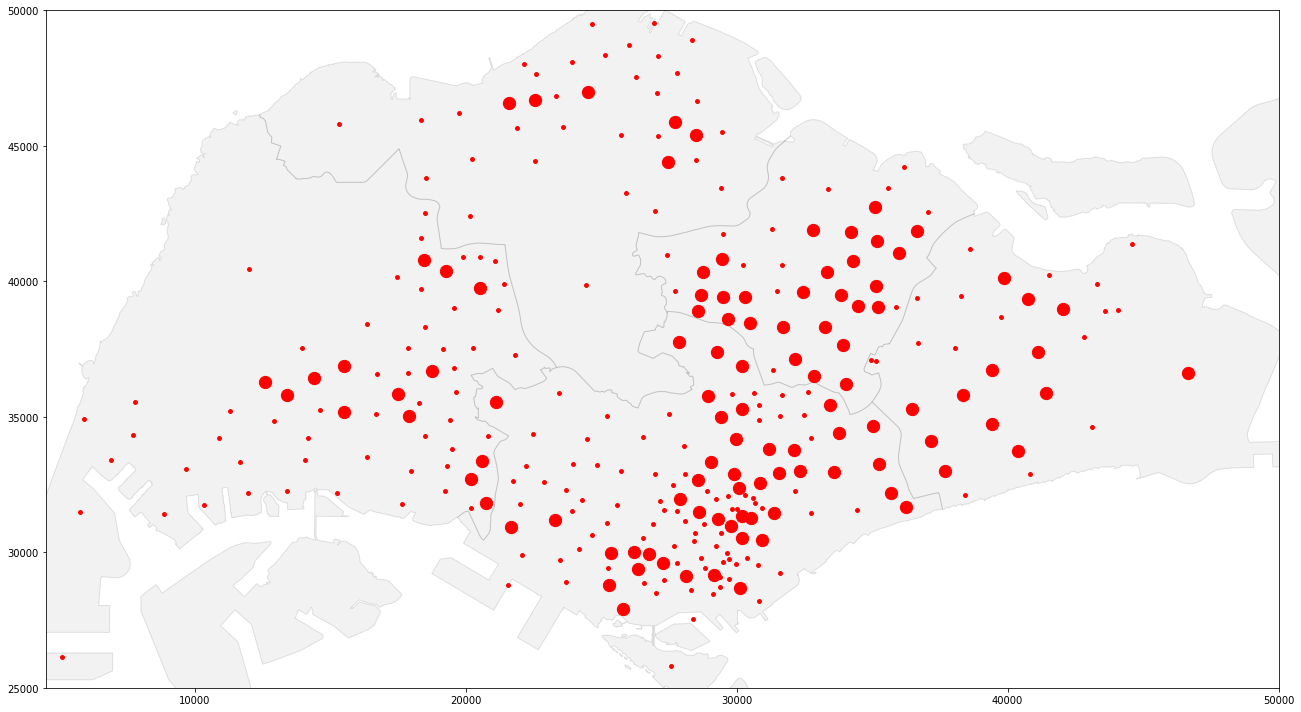

In [209]:
max_ks = max(node_ks.values())
fig, ax = plt.subplots(figsize=(20,10))
ax.set_aspect("equal")
#nx.draw_networkx_nodes(dg1b, pos=pos, node_size=[ node_ks[n]/100 for n in dg1b.nodes() ])
nx.draw_networkx_nodes(dg1b, nodelist=[ n for n,v in node_ks.items() if v>=max_ks ], pos=pos, node_size=150)
nx.draw_networkx_nodes(dg1b, nodelist=[ n for n,v in node_ks.items() if v<max_ks ], pos=pos, node_size=15)

region.plot(color="grey", edgecolor="k", alpha=0.1, ax=ax)
ax.set_xlim([4500,50000])
ax.set_ylim([25000,50000])
plt.tight_layout()

100%|██████████| 303/303 [00:01<00:00, 163.10it/s]


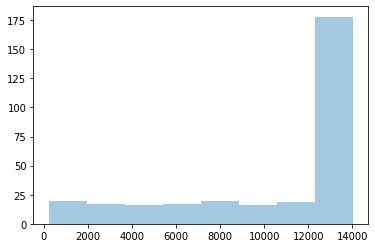

In [191]:
node_ks2 = decomposition(dg1b.copy(), direction="out", alpha=1., beta=1., group_k_by=1)
sns.distplot(list(node_ks2.values()),kde=False)#, bins=[i*1 for i in range(9)])

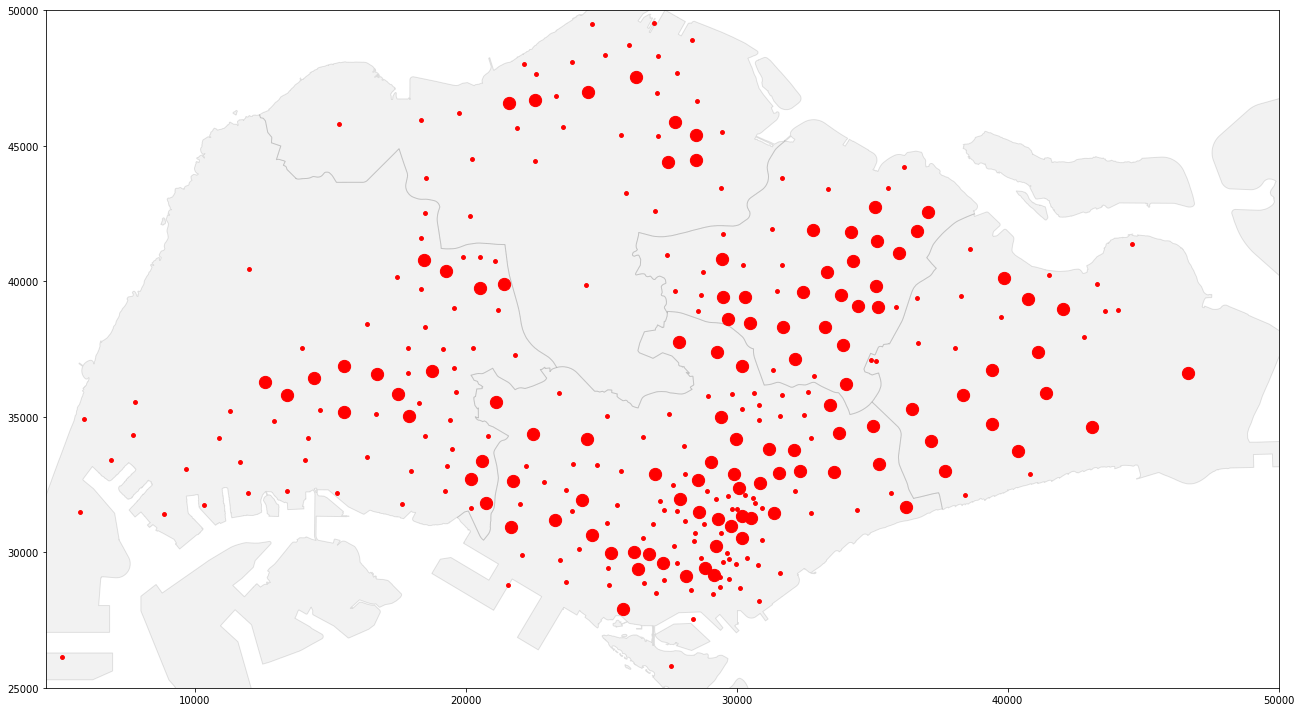

In [195]:
max_ks2 = max(node_ks2.values())
fig, ax = plt.subplots(figsize=(20,10))
ax.set_aspect("equal")
#nx.draw_networkx_nodes(dg1b, pos=pos, node_size=[ node_ks[n]/100 for n in dg1b.nodes() ])
nx.draw_networkx_nodes(dg1b, nodelist=[ n for n,v in node_ks2.items() if v>=max_ks2 ], pos=pos, node_size=150)
nx.draw_networkx_nodes(dg1b, nodelist=[ n for n,v in node_ks2.items() if v<max_ks2 ], pos=pos, node_size=15)

region.plot(color="grey", edgecolor="k", alpha=0.1, ax=ax)
ax.set_xlim([4500,50000])
ax.set_ylim([25000,50000])
plt.tight_layout()

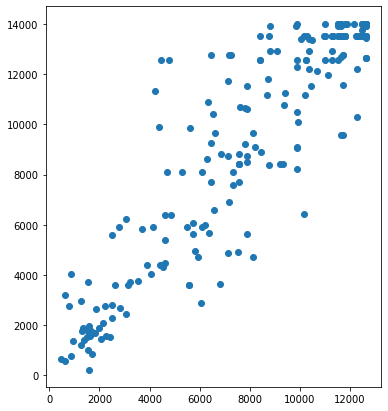

In [217]:
df_ks = pd.DataFrame.from_dict({"in_core":node_ks, "out_core":node_ks2})
#df_ks.head()
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(df_ks["in_core"], df_ks["out_core"])
ax.set_aspect("equal")

In [216]:
dg1b.weighted

AttributeError: 'DiGraph' object has no attribute 'weighted'

In [147]:
kshell, kshell_val = decomposition(dg1b.copy(), direction="in", alpha=1., beta=1.)

100%|██████████| 303/303 [00:03<00:00, 81.95it/s] 


<BarContainer object of 14 artists>

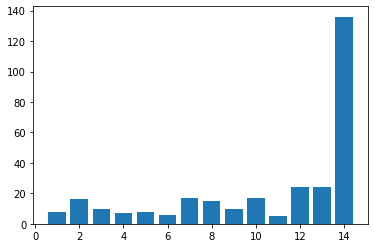

In [150]:
tempx = []
tempy = []
temp = defaultdict(int)
for k in kshell:
    #print(k, kshell_val[k], len(kshell[k]))
    tempx.append(kshell_val[k])
    tempy.append(len(kshell[k]))
    temp[int(round(kshell_val[k]/1000))]+=len(kshell[k])
plt.bar(temp.keys(), temp.values())
#plt.bar(tempx, tempy)

<BarContainer object of 136 artists>

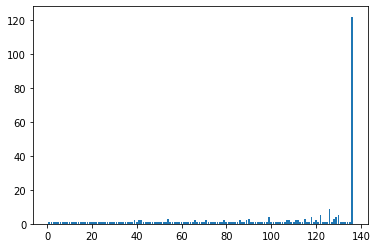

In [151]:
tempx = []
tempy = []
temp = defaultdict(int)
for k in kshell:
    #print(k, kshell_val[k], len(kshell[k]))
    tempx.append(kshell_val[k])
    tempy.append(len(kshell[k]))
    temp[k]+=len(kshell[k])
plt.bar(temp.keys(), temp.values())
#plt.bar(tempx, tempy)

In [110]:
#dg1b.number_of_nodes()

303

In [70]:
0.0001 / 0.0001#5 /0.6666666666666667


1.0

In [71]:
0.0002 / 0.0001#5 /0.66666666666666667

2.0

In [72]:
0.00013 / 0.0001#5 /0.66666666666666667

1.2999999999999998

In [73]:
1000000 / 1000000#1500000 / 0.6666666666666666

1.0

In [74]:
2000000 / 1000000#1500000 / 0.6666666666666666

2.0

In [75]:
1300000 / 1000000#1500000 / 0.6666666666666666

1.3

In [48]:
closeness = nx.closeness_centrality(dg1b, distance="weight")
closeness

{'SENOKO NORTH': 88684.9591108608,
 'YISHUN CENTRAL': 106756.7036301909,
 'SEMBAWANG EAST': 94086.50138297224,
 'WOODLANDS WEST': 112893.9023180844,
 'THE WHARVES': 69559.57573251927,
 'SEMBAWANG SPRINGS': 88152.12007654052,
 'ADMIRALTY': 93628.50742544216,
 'SPRINGLEAF': 57830.33766527145,
 'YISHUN WEST': 108392.22286161958,
 'SENOKO WEST': 98809.09175036452,
 'TAGORE': 76775.89746532621,
 'SEMBAWANG STRAITS': 64734.89727703523,
 'KHATIB': 102682.7233683519,
 'NORTHLAND': 105750.05599131147,
 'WOODLANDS REGIONAL CENTRE': 116586.95404578773,
 'SENOKO SOUTH': 103682.51661751089,
 'SHANGRI-LA': 89013.68661313887,
 'ANG MO KIO TOWN CENTRE': 98109.89113971165,
 'GREENWOOD PARK': 96528.04149905528,
 'KEBUN BAHRU': 94935.66856897241,
 'SEMBAWANG HILLS': 68875.18767789444,
 'SEMBAWANG CENTRAL': 104136.21945450075,
 'HOLLAND ROAD': 95223.51075413471,
 'YIO CHU KANG': 91922.22466798151,
 'SUNGEI ROAD': 53402.55208587644,
 'BALESTIER': 107689.36227910475,
 'BUKIT BATOK CENTRAL': 93019.0240134658

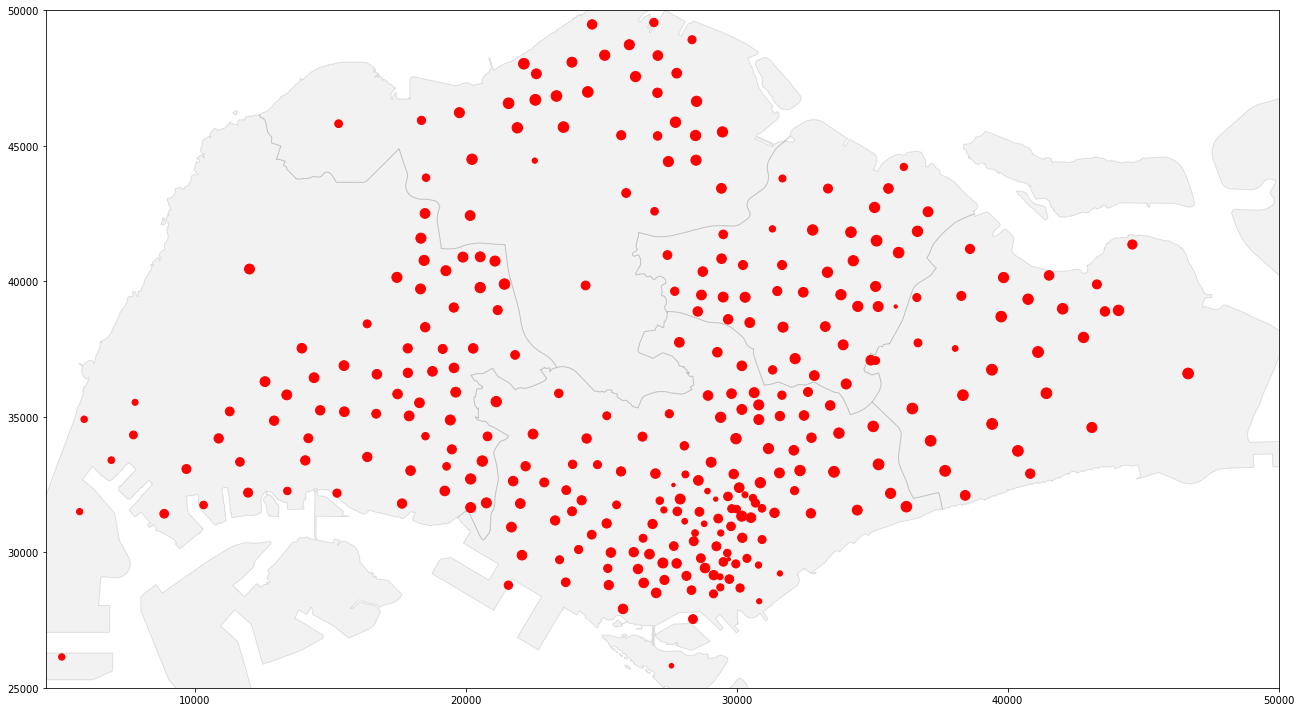

In [50]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_aspect("equal")
region.plot(ax=ax, color="grey", edgecolor="k", alpha=0.1)

cs = [ closeness[n]/1000 for n in dg1b.nodes() ]
nx.draw_networkx_nodes(dg1b, pos=pos, node_size=cs, ax=ax)
#nx.draw_networkx_edges(dg1, pos=pos, ax=ax)

ax.set_xlim([4500,50000])
ax.set_ylim([25000,50000])
plt.tight_layout()

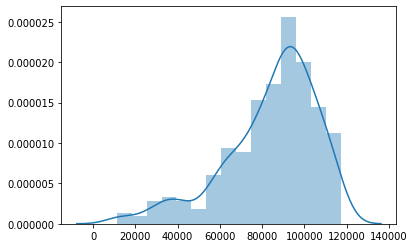

In [51]:
sns.distplot( list(closeness.values()) )